In [20]:
print("hello")

from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json

#test
# json_path="./helm_output/eval_1/wmt/distilbert_distilgpt2/2_beams/runs/eval_1/generation_summary.json"

#full 8B 4beam
json_path="/Users/lukecadigan/thesis/helm/full_tests/llama_8b_4beam.json"


with open(json_path,'r') as json_file:
    generation_summary_dict=json.load(json_file)

hello


In [21]:
from helm.common.request import (GeneratedOutput)

In [22]:
def json_to_instance_generation(instance_dict:dict) -> InstanceGenerations:
    instance_generation = InstanceGenerations(**instance_dict)
    examples = [ GeneratedOutput(**generated_output_dict) for generated_output_dict in instance_generation.examples]
    instance_generation.examples=examples
    return instance_generation

generation_summary=GenerationSummary(**generation_summary_dict)
instance_generations = [json_to_instance_generation(instance_dict)  for instance_dict in generation_summary.instance_generations ]
generation_summary.instance_generations=instance_generations
print("example completion:")
print(generation_summary.instance_generations[0].examples[0].text)


example completion:
 He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.


In [23]:
def truncate_sequence(text, all_stops=["<|end_of_text|>"]):
    for stop in all_stops:
        try:
            text = text[: text.index(stop)]
        except ValueError:
            pass
    return text


In [24]:
from dataclasses import dataclass

from abc import abstractmethod, ABC

from helm.benchmark.metrics.evaluate_reference_metrics import bleu_4

class PostMetric(ABC):
    @property
    @abstractmethod
    def name(self)->str:
        pass
    @abstractmethod
    def calculate_metric(self, instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        pass

class SentenceLenMetric(PostMetric):
    @classmethod
    def name(cls)->str:
        return "completion_length"
    @classmethod    
    def calculate_metric(self,instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        return len(generated_output.text)
    
class CompletionProbMetric(PostMetric):
    @classmethod
    def name(cls)->str:
        return "completion_logprob"
    @classmethod    
    def calculate_metric(self,instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        return generated_output.logprob
    
class InstanceIdMetric(PostMetric):
    @classmethod
    def name(cls)->str:
        return "instanceID"
    @classmethod
    def calculate_metric(self, instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        return instance_generation.instance_id


class BLEU_METRIC(PostMetric):
    @classmethod
    def name(cls)->str:
        return "BLEU"
    @classmethod
    def calculate_metric(self,instance_generation:InstanceGenerations,generated_output:GeneratedOutput) -> float:
        sys=[]
        reference = instance_generation.reference
        completion=truncate_sequence(generated_output.text).strip()
        print(f"completion is {completion}")
        print(f"reference is  {reference}")
        return bleu_4(completion,reference)


        
base_metrics=[SentenceLenMetric(),CompletionProbMetric(), InstanceIdMetric()]
new_metrics = [BLEU_METRIC()]
metrics=base_metrics+new_metrics

metrics_dicts=[]
counter=0
for instance_generation in instance_generations:
    for generated_output in instance_generation.examples:
        metrics_dict={}
        for metric in metrics:
            metrics_dict[metric.name()] = metric.calculate_metric(instance_generation, generated_output)
        metrics_dicts.append(metrics_dict)                

completion is He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
reference is  He advised the parents of a boy whose penis had been severed in a botched circumcision to have the child fully castrated, removing his testicles, as well, and to raise him as a girl.
completion is He advised the parents of a boy whose penis had been severed during a botched circumcision to castrate the child completely and remove his testicles and then raise him as a girl.
reference is  He advised the parents of a boy whose penis had been severed in a botched circumcision to have the child fully castrated, removing his testicles, as well, and to raise him as a girl.
completion is He advised the parents of a boy whose penis had been severed in a botched circumcision to castrate the child completely, remove his testicles, and then raise him as a girl.
reference is  He advised the parents 

/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

completion is This remarkable voluntary engagement was also commended by the state parliamentarian Karl Rombach.
reference is  This remarkable voluntary commitment was also honoured by Member of the State Parliament, Karl Rombach.
completion is This remarkable voluntary engagement was also appreciated by the state parliament member Karl Rombach.
reference is  This remarkable voluntary commitment was also honoured by Member of the State Parliament, Karl Rombach.
completion is Nevertheless, there are still 81,500 complaints waiting to be settled in the office.
reference is  Nonetheless, there are still 81,500 appeals waiting to be resolved in the office.
completion is Nevertheless, 81,500 complaints are still pending in the office.
reference is  Nonetheless, there are still 81,500 appeals waiting to be resolved in the office.
completion is Nevertheless, there are still 81,500 complaints waiting to be dealt with in the office.
reference is  Nonetheless, there are still 81,500 appeals wait

In [25]:
import pandas as pd
df = pd.DataFrame(metrics_dicts)

In [36]:
print(df["BLEU"].mean())
print(df.keys())

0.1604263848237301
Index(['completion_length', 'completion_logprob', 'instanceID', 'BLEU'], dtype='object')


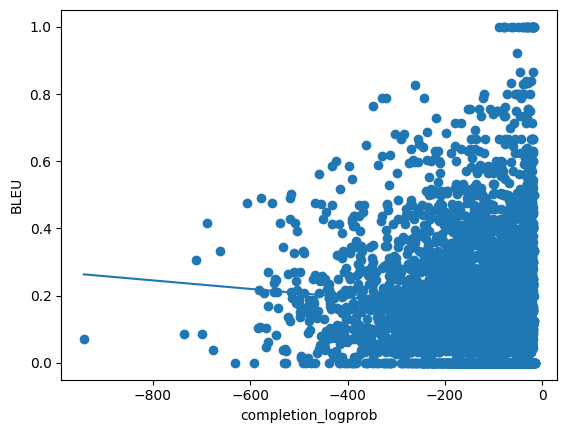

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_keys(xlabel, ylabel):
    x=df[xlabel]
    y=df[ylabel]
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.show()

plot_keys("completion_logprob","BLEU")


In [35]:

for instance_generation in instance_generations:
    for generated_output in instance_generation.examples:
        if(generated_output.logprob>-50):
            instance_generation.reference
            print(generated_output.text)
            print(" ".join([token["text"] for token in generated_output.tokens]))

 Airbus states that the competing version of the A350 carries 350 people in 18-inch seats in economy class, with nine per row.
 Airbus  states  that  the  competing  version  of  the  A 350  carries   350  people  in   18 -inch  seats  in  economy  class ,  with  nine  per  row . <|end_of_text|>
 According to the Associated Press, the target was Russian SA-125 missiles.
 According  to  the  Associated  Press ,  the  target  was  Russian  SA - 125  missiles . <|end_of_text|>
 The text, which was adopted last night, consists of 234 articles.
 The  text ,  which  was  adopted  last  night ,  consists  of   234  articles . <|end_of_text|>
 The text that was adopted last night consists of 234 articles.
 The  text  that  was  adopted  last  night  consists  of   234  articles . <|end_of_text|>
 He only stirs up enthusiasm with difficulty.
 He  only  st irs  up  enthusiasm  with  difficulty . <|end_of_text|>
 He only rarely inspires enthusiasm.
 He  only  rarely  inspires  enthusiasm . <|end_